# $\epsilon$-greedy

In [430]:
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial

In [431]:
import pandas as pd

In [432]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The 10-armed Testbed

In [433]:
key = random.PRNGKey(31415)

key_bandit, key_sample = random.split(key, 2)
n_bandits = 10
true_values = random.normal(key_bandit, (n_bandits,))
true_values

DeviceArray([ 0.09987481, -0.2125681 ,  1.4521614 , -0.8110563 ,
             -0.89297926,  0.61249924, -1.8329982 ,  0.21462014,
             -0.8210585 ,  0.38306195], dtype=float32)

In [434]:
n_samples = 5000
bandit_samples = random.normal(key_sample, (n_bandits, n_samples)) + true_values[:, None]
bandit_samples.shape

(10, 5000)

In [435]:
bandit_samples = pd.DataFrame(bandit_samples.T).melt()
bandit_samples = bandit_samples.rename({"variable":"action", "value":"reward"}, axis=1)

(-4.0, 4.0)

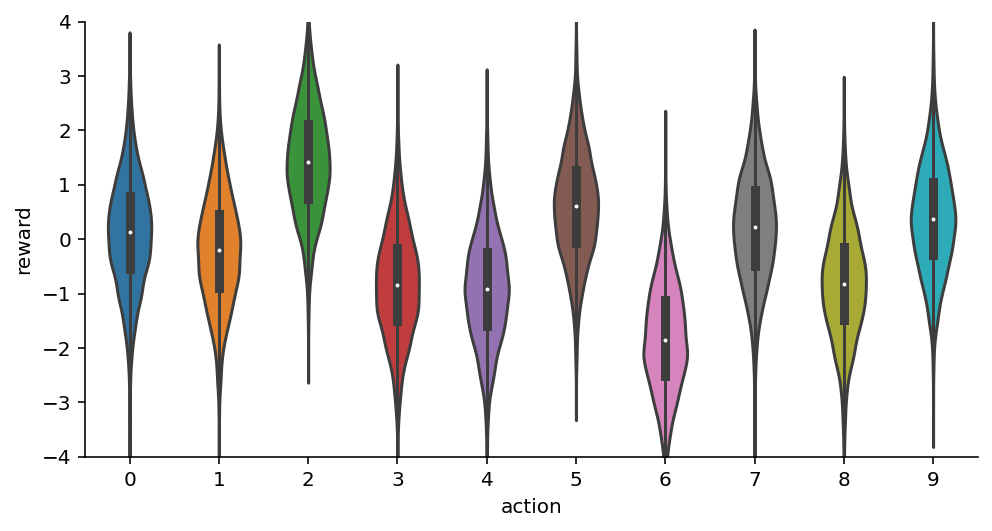

In [436]:
plt.subplots(figsize=(8, 4))
sns.violinplot(x="action", y="reward", data=bandit_samples, width=0.5)
plt.ylim(-4, 4)

## $\epsilon$-greedy method

$$
    Q_t(a) := \frac{\sum_{\tau=1}^{t-1} R_\tau \mathbb{1}(A_{\tau=a})}{\sum_{\tau=1}^{t-1} \mathbb{1}(A_{\tau=a})}
$$

In [437]:
num_steps = 1000
eps = 0.01
bandits = jnp.arange(n_bandits)
key_step = random.PRNGKey(3141)

In [438]:
def take_greedy(state, key, eps):
    num_visits, cumulative_rewards = state
    key_action_random, key_action_greedy, key_reward, key_greedy = random.split(key, 4)
    
    Qt = cumulative_rewards / jnp.maximum(num_visits, 1)
    take_greedy = (jax.random.uniform(key_greedy) > eps) * 1.0
    
    map_choice = Qt.max() == Qt
    prob_choice_Q = map_choice / map_choice.sum()
    
    greedy_action = random.choice(key_action_greedy, bandits, p=prob_choice_Q)
    random_action = random.choice(key_action_random, bandits)
    
    action = take_greedy * greedy_action + (1 - take_greedy) * random_action
    reward = random.normal(key_reward) + true_values[action.astype(int)]
    
    action_ohe = jax.nn.one_hot(action, n_bandits)
    num_visits = num_visits + action_ohe
    cumulative_rewards = cumulative_rewards + action_ohe * reward
    
    return (num_visits, cumulative_rewards), (reward, action)


def epsilon_learn(key, eps, num_steps, init_rewards):
    keys = random.split(key, num_steps)
    take_greedy_eps = partial(take_greedy, eps=eps)
    num_visits = jnp.zeros_like(init_rewards)
    
    init_state = (num_visits, init_rewards)
    (num_visits, cumulative_rewards), (reward_hist, action_hist) = jax.lax.scan(take_greedy_eps, init_state, keys)
    return (num_visits, cumulative_rewards), (reward_hist, action_hist)


# Note: 
# 1. vmap (0, 0, None, None) is not the same as 'vmapping'
# 2. first over (0, None, None, None) and then over (None, 0, None, None).
# The behaviour of 1. is one-to-one, the behaviour of 2. is cross-product

# vmap over keys for multiple samples
epsilon_learn = jax.vmap(epsilon_learn, (0, None, None, None))
# vmap over eps for multiple configurations
epsilon_learn = jax.vmap(epsilon_learn, (None, 0, None, None))

## Epsilon greedy

In [439]:
nsims = 2000
num_steps = 1000
init_rewards = jnp.zeros(n_bandits)

key = random.PRNGKey(314)
keys = random.split(key, nsims)
eps_values = jnp.array([0., 0.01, 0.1, 0.7])

_, (reward_sims_multiple, action_sims_multiple) = epsilon_learn(keys, eps_values, num_steps, init_rewards)

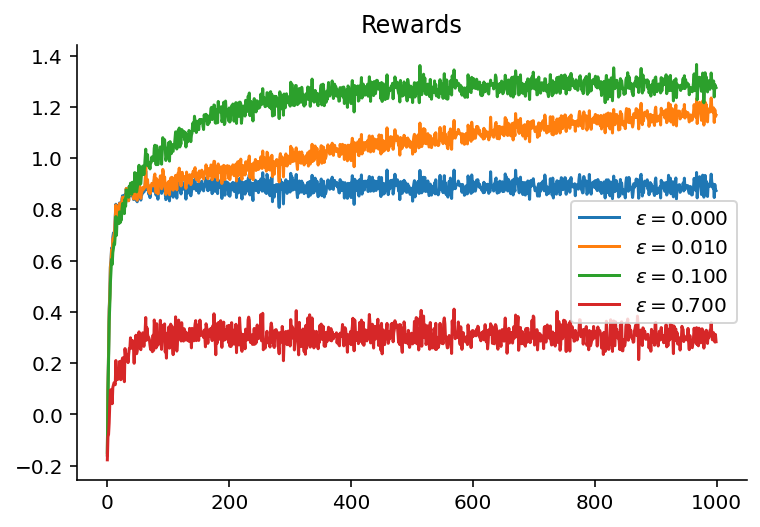

In [440]:
plt.plot(reward_sims_multiple.mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.title("Rewards")
plt.legend(legends);

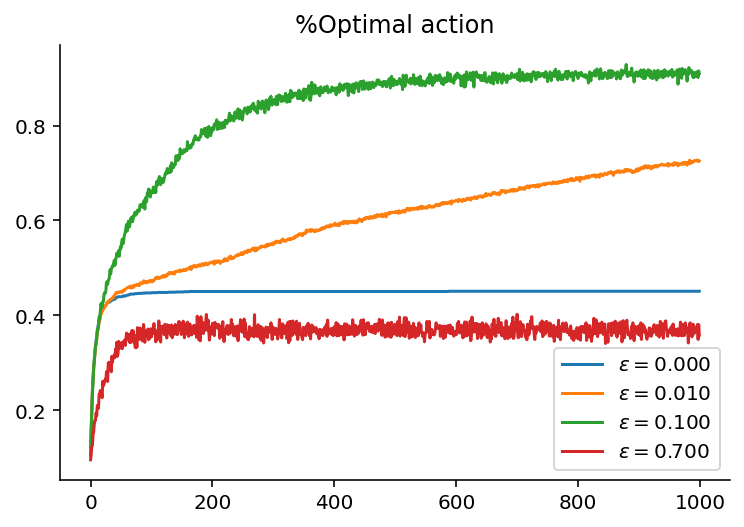

In [441]:
plt.title("%Optimal action")
plt.plot((action_sims_multiple == true_values.argmax()).mean(axis=1).T)
legends = ["$\epsilon=$"f"{eps:0.3f}" for eps in eps_values]
plt.legend(legends);

## Optimistic initial values

In [442]:
# vmap over multiple initial configurations
epsilon_learn_config = jax.vmap(epsilon_learn, (None, None, None, 0))

In [443]:
nsims = 2000
key = random.PRNGKey(314)
keys = random.split(key, nsims)
eps_values = jnp.array([0., 0.1, 0.01])

In [444]:
init_rewards_multiple = jnp.stack([jnp.zeros(n_bandits), jnp.ones(n_bandits) * 5.0], axis=0)

In [447]:
_, (reward_sims_multiple, action_sims_multiple) = epsilon_learn_config(keys, eps_values, num_steps, init_rewards_multiple)

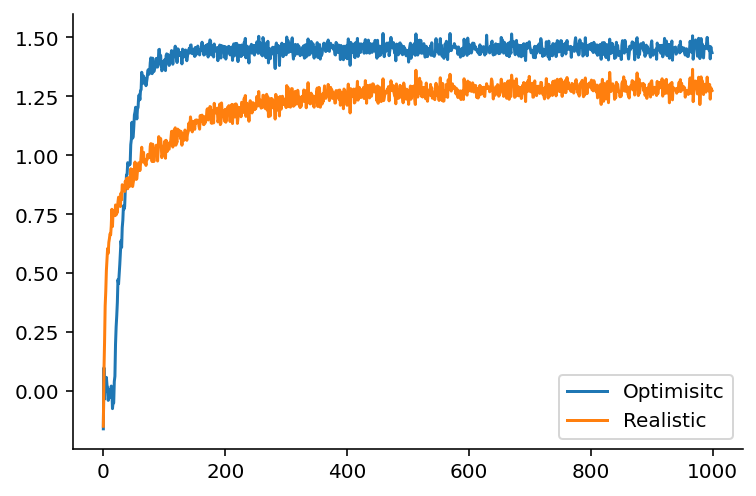

In [448]:
plt.plot(reward_sims_multiple[1, 0].mean(axis=0), label="Optimisitc")
plt.plot(reward_sims_multiple[0, 1].mean(axis=0), label="Realistic")
plt.legend()

Text(0.5, 1.0, '% optimal choice')

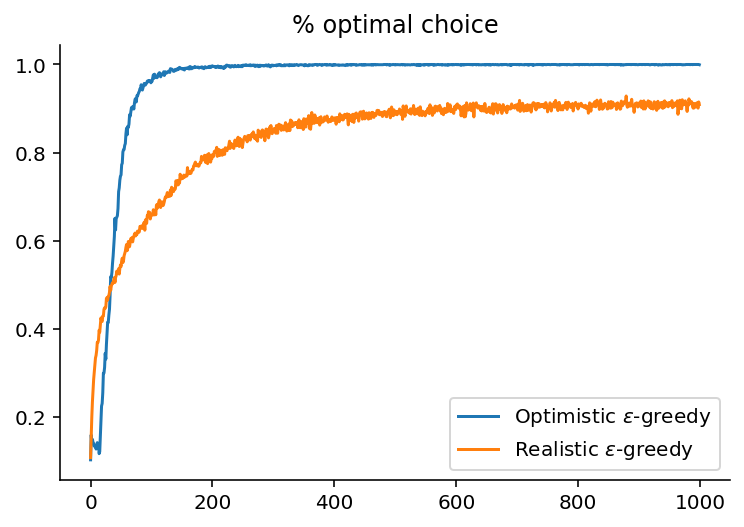

In [455]:
optimistic_pct = (action_sims_multiple[1, 0] == true_values.argmax()).mean(axis=0)
real_pct = (action_sims_multiple[0, 1] == true_values.argmax()).mean(axis=0)
plt.plot(optimistic_pct, label="Optimistic $\epsilon$-greedy")
plt.plot(real_pct, label="Realistic $\epsilon$-greedy")
plt.legend()
plt.title("% optimal choice")